In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
# Load data
df = pd.read_csv("../data/qqq_supervised.csv", index_col=0, parse_dates=True)
feature_cols = [col for col in df.columns if col != 'Target' and not col.endswith("Return")]
X = df[feature_cols]
y = df['Target']

In [13]:
# Load scalers and models
scaler = joblib.load("../models/day7_xgb_scaler.pkl")
X_scaled = scaler.transform(X)

xgb_model = XGBClassifier()
xgb_model.load_model("../models/day7_xgb_multi_etf_classifier.json")

lstm_scaler = joblib.load("../models/day8_lstm_scaler.pkl")
X_lstm_scaled = lstm_scaler.transform(X)

# Create sequences for LSTM
SEQ_LEN = 20
X_seq = []
y_seq = []
for i in range(SEQ_LEN, len(X_lstm_scaled)):
    X_seq.append(X_lstm_scaled[i-SEQ_LEN:i])
    y_seq.append(y.iloc[i])

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

split = int(0.8 * len(X_seq))
X_seq_test = torch.tensor(X_seq[split:], dtype=torch.float32)
y_seq_test = torch.tensor(y_seq[split:], dtype=torch.float32)

In [14]:
# Define LSTM model structure
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return self.sigmoid(out)

input_dim = X_seq.shape[2]
lstm_model = LSTMClassifier(input_dim, 64, 2)
lstm_model.load_state_dict(torch.load("../models/day8_lstm_model.pt"))
lstm_model.eval()

LSTMClassifier(
  (lstm): LSTM(35, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [15]:
# Evaluate LSTM
with torch.no_grad():
    lstm_preds = lstm_model(X_seq_test).squeeze()
    lstm_preds_bin = (lstm_preds > 0.5).int().numpy()

In [16]:
# Evaluate XGBoost
X_xgb_test = X_scaled[-len(X_seq_test):]
y_xgb_test = y_seq[-len(X_seq_test):]
xgb_preds = xgb_model.predict(X_xgb_test)

In [17]:
# Metric Comparison using classification_report
def print_metrics(y_true, y_pred, label):
    print(f"\n{label} Metrics")
    print(classification_report(y_true, y_pred, digits=2))

# Call the function for both models
print_metrics(y_seq_test, lstm_preds_bin, "LSTM")
print_metrics(y_xgb_test, xgb_preds, "XGBoost")


LSTM Metrics
              precision    recall  f1-score   support

         0.0       0.81      0.85      0.83        46
         1.0       0.97      0.96      0.97       247

    accuracy                           0.95       293
   macro avg       0.89      0.91      0.90       293
weighted avg       0.95      0.95      0.95       293


XGBoost Metrics
              precision    recall  f1-score   support

           0       0.98      0.96      0.97        46
           1       0.99      1.00      0.99       247

    accuracy                           0.99       293
   macro avg       0.98      0.98      0.98       293
weighted avg       0.99      0.99      0.99       293



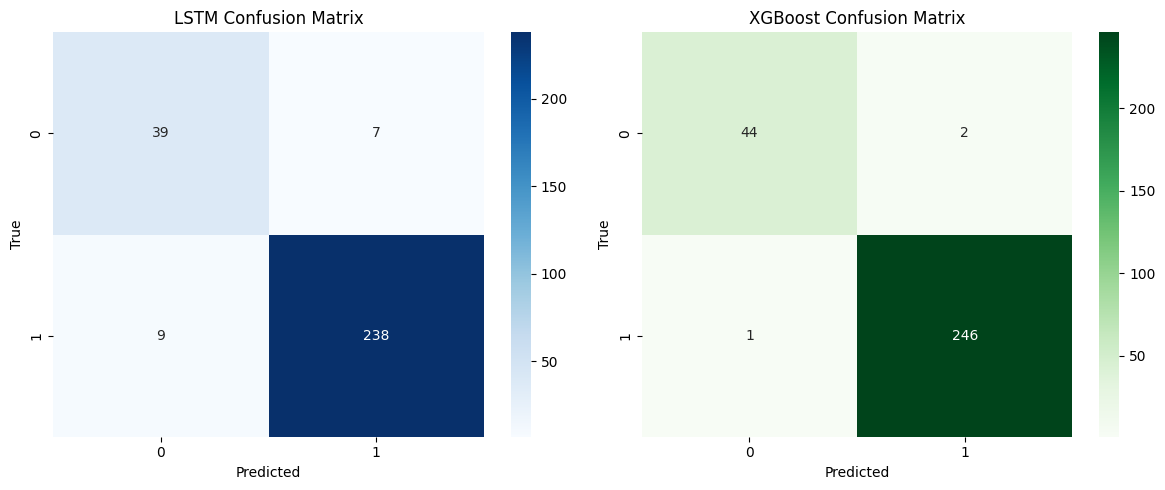

In [18]:
# Confusion Matrices 
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_seq_test, lstm_preds_bin), annot=True, fmt='d', ax=axs[0], cmap="Blues")
axs[0].set_title("LSTM Confusion Matrix")
axs[0].set_xlabel("Predicted")
axs[0].set_ylabel("True")

sns.heatmap(confusion_matrix(y_xgb_test, xgb_preds), annot=True, fmt='d', ax=axs[1], cmap="Greens")
axs[1].set_title("XGBoost Confusion Matrix")
axs[1].set_xlabel("Predicted")
axs[1].set_ylabel("True")

plt.tight_layout()
plt.savefig("../figures/day9_lstm_vs_xgb_confusion.png", dpi=300)
plt.show()